In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import statistics

# Scrape Data from Pro Football Reference

Pro Football Reference has a list of all QBs who have ever played. They have a metric (AV == Approximate Value) that tries to determine the career value of a QB. No surprises here, Brady is #1. 

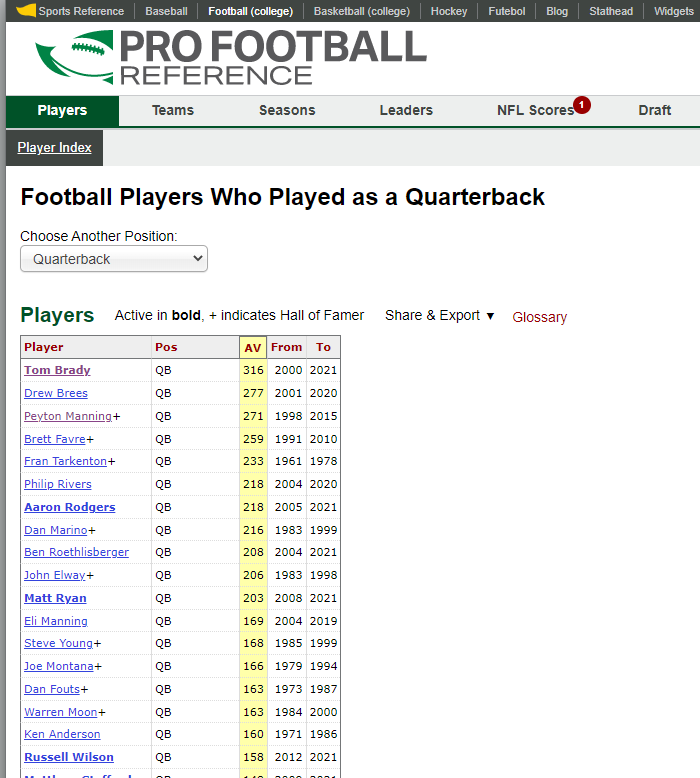

Our goal will be to make QB tiers out of this AV and try to predict the tier a QB will land in, given his rookie stats.

In [16]:
url = "https://www.pro-football-reference.com/"
r = requests.get("https://www.pro-football-reference.com/players/qbindex.htm")
soup = BeautifulSoup(r.content, 'html.parser')
parsed_table = soup.find_all('table')[0]  

### For each QB, get their stats page and filter out stats from their table

I will define "rookie year" as the first year where the QB started > 2 games in a season.
I will also arbitraly decide to filter out QBs who played less than 2 years in the league, with a year being defined as starting > 2 games in a season. 

In [6]:
rookie_year = []
for i,row in enumerate(tqdm(parsed_table.find_all('tr')[1:])):
        try:
            name = row.a.get_text()
            stub = row.a.get('href')
            av = row.find('td', 
                attrs={'data-stat': 'av'}).get_text()
            year_min = row.find('td', 
                attrs={'data-stat': 'year_min'}).get_text()        
            if int(year_min) >= 1969:
                qb_data = pd.read_html(url + stub)[0]   
                # Replace strings with 0s
                qb_data = qb_data.replace(r'[^0-9]', 0, regex=True)
                # Select 1st year where they started > 2 games as 'Rookie Year' 
                qb_data_filtered = qb_data[qb_data["GS"] > 2]
                # Add name and career_av to data 
                qb_data_filtered.insert(0, "Name", name)
                last_row = len(qb_data_filtered.iloc[0])
                qb_data_filtered.insert(last_row, "Career_AV", int(av))
                # Filter out QBs who started only a few games in their career
                if len(qb_data_filtered) >= 2:
                    rookie_year.append(qb_data_filtered.iloc[0])
                
        except Exception:
            pass
    

100%|██████████████████████████████████████████████████████████████████████████████| 1035/1035 [07:27<00:00,  2.31it/s]


In [7]:
rookie_year = pd.DataFrame(rookie_year)

In [15]:
len(rookie_year)

406

This means there are 406 QBs that qualify

In [20]:
rookie_year.head()

,Name,Year,Age,Tm,Pos,No.,G,GS,QBrec,Cmp,...,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD,AV,Awards,Career_AV,Tier
1,Tom Brady,0,24,0.0,0.0,12.0,15,14.0,0.0,264,...,216,9.0,5.79,5.39,3.0,3.0,12,0.0,316,Elite Career QB
1,Drew Brees,2002,23,0.0,0.0,9.0,16,16.0,0.0,320,...,180,4.4,5.64,4.95,2.0,4.0,10,0.0,277,Elite Career QB
1,Brett Favre,0,23,0.0,0.0,4.0,15,13.0,0.0,302,...,208,6.7,5.98,5.53,3.0,3.0,13,0.0,259,Elite Career QB
2,Philip Rivers,0,25,0.0,0.0,17.0,16,16.0,0.0,284,...,144,5.5,6.66,6.73,4.0,4.0,18,0.0,218,Elite Career QB
3,Aaron Rodgers,2008,25,0.0,0.0,12.0,16,16.0,0.0,341,...,231,6.0,6.68,6.64,1.0,2.0,15,0.0,218,Elite Career QB


In [17]:
rookie_year = rookie_year.fillna(0)

I will then assume the Career_AV is a normal distribution, and create zscore "tiers" for each QB

In [11]:
dist = statistics.NormalDist.from_samples(rookie_year["Career_AV"])
def pred_to_tier(row):
    zscore = dist.zscore(row["Career_AV"])
    # Decided to influence the zscore a bit. 
    # Any QB with negative Career AV deserves bottom tier
    if row["Career_AV"] < 0:
        tier = "Poor Career QB"
    elif zscore > 1.5:
        tier = "Elite Career QB"
    elif zscore > 0.5 and zscore < 1.5:
        tier = "Above Average Career QB"
    elif zscore > -0.5 and zscore < 0.5:
        tier = "Average Career QB"
    elif zscore > -1.5 and zscore < -0.5:
        tier = "Below-Average Career QB"
    else:
        tier = "Poor Career QB"
    return tier

In [12]:
rookie_year['Tier'] = rookie_year.apply(lambda row: pred_to_tier(row), axis=1)

In [13]:
rookie_year["Tier"].value_counts()

Below-Average Career QB    179
Average Career QB          137
Above Average Career QB     52
Elite Career QB             35
Poor Career QB               3
Name: Tier, dtype: int64

In [18]:
rookie_year.to_csv("rookie_year.csv") # Save as CSV for next Step